In [8]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.special import erf
from scipy.odr import ODR, Model, RealData
from scipy.optimize import curve_fit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

from astropy import units as u
from astropy.coordinates import SkyCoord

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import rz_table, FP_func

from scipy.stats import norm
from scipy import special
import math

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))

def FN_func(FPparams, zobs, er, es, ei, lmin, lmax, smin):

    a, b, rmean, smean, imean, sigma1, sigma2, sigma3 = FPparams
    k = 0.0

    fac1, fac2, fac3, fac4 = k*a**2 + k*b**2 - a, k*a - 1.0 - b**2, b*(k+a), 1.0 - k*a
    norm1, norm2 = 1.0+a**2+b**2, 1.0+b**2+k**2*(a**2+b**2)-2.0*a*k
    dsigma31, dsigma23 = sigma3**2-sigma1**2, sigma2**2-sigma3**3
    sigmar2 =  1.0/norm1*sigma1**2 +      b**2/norm2*sigma2**2 + fac1**2/(norm1*norm2)*sigma3**2
    sigmas2 = a**2/norm1*sigma1**2 + k**2*b**2/norm2*sigma2**2 + fac2**2/(norm1*norm2)*sigma3**2
    sigmai2 = b**2/norm1*sigma1**2 +   fac4**2/norm2*sigma2**2 + fac3**2/(norm1*norm2)*sigma3**2
    sigmars =  -a/norm1*sigma1**2 -   k*b**2/norm2*sigma2**2 + fac1*fac2/(norm1*norm2)*sigma3**2
    sigmari =  -b/norm1*sigma1**2 +   b*fac4/norm2*sigma2**2 + fac1*fac3/(norm1*norm2)*sigma3**2
    sigmasi = a*b/norm1*sigma1**2 - k*b*fac4/norm2*sigma2**2 + fac2*fac3/(norm1*norm2)*sigma3**2

    err_r = er**2 + np.log10(1.0 + 300.0/(LIGHTSPEED*zobs))**2 + sigmar2
    err_s = es**2 + sigmas2
    err_i = ei**2 + sigmai2
    cov_ri = -1.0*er*ei + sigmari

    A = err_s*err_i - sigmasi**2
    B = sigmasi*cov_ri - sigmars*err_i
    C = sigmars*sigmasi - err_s*cov_ri
    E = err_r*err_i - cov_ri**2
    F = sigmars*cov_ri - err_r*sigmasi
    I = err_r*err_s - sigmars**2

    # Inverse of the determinant!!
    det = 1.0/(err_r*A + sigmars*B + cov_ri*C)

    # Compute all the G, H and R terms
    G = np.sqrt(E)/(2*F-B)*(C*(2*F+B) - A*F - 2.0*B*I)
    delta = (I*B**2 + A*F**2 - 2.0*B*C*F)*det**2
    Edet = E*det
    Gdet = (G*det)**2
    Rmin = (lmin - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)
    Rmax = (lmax - rmean - imean/2.0)*np.sqrt(2.0*delta/det)/(2.0*F-B)

    G0 = -np.sqrt(2.0/(1.0+Gdet))*Rmax
    G2 = -np.sqrt(2.0/(1.0+Gdet))*Rmin
    G1 = -np.sqrt(Edet/(1.0+delta))*(smin - smean)

    H = np.sqrt(1.0+Gdet+delta)
    H0 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmax
    H2 = G*det*np.sqrt(delta) - np.sqrt(Edet/2.0)*(1.0+Gdet)*(smin - smean)/Rmin
    H1 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmax/(smin - smean)
    H3 = G*det*np.sqrt(delta) - np.sqrt(2.0/Edet)*(1.0+delta)*Rmin/(smin - smean)

    FN = special.owens_t(G0, H0/H)+special.owens_t(G1, H1/H)-special.owens_t(G2, H2/H)-special.owens_t(G1, H3/H)
    FN += 1.0/(2.0*np.pi)*(np.arctan2(H2,H)+np.arctan2(H3,H)-np.arctan2(H0,H)-np.arctan2(H1,H))
    FN += 1.0/4.0*(special.erf(G0/np.sqrt(2.0))-special.erf(G2/np.sqrt(2.0)))

    # This can go less than zero for very large distances if there are rounding errors, so set a floor
    # This shouldn't affect the measured logdistance ratios as these distances were already very low probability!
    index = np.where(FN < 1.0e-15)
    FN[index] = 1.0e-15

    return np.log(FN)

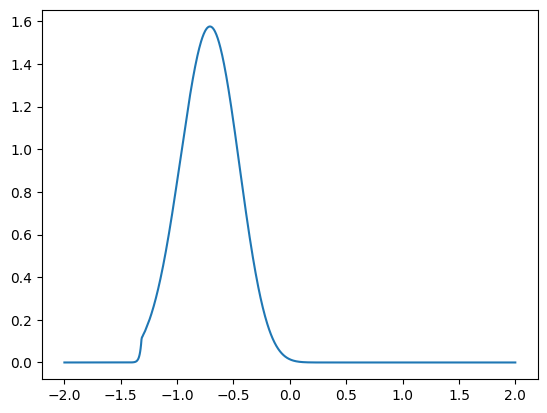

In [3]:
dbins = np.linspace(-2, 2, 1001)
y_ = np.load("./malmquist_prior/logdist/6dfgs_posterior.npy")
# y_ = np.load("../../artifacts/logdist/smin_setting_1/fp_fit_method_0/6dfgs_posterior.npy")

y = y_[3916]
plt.plot(dbins, y)

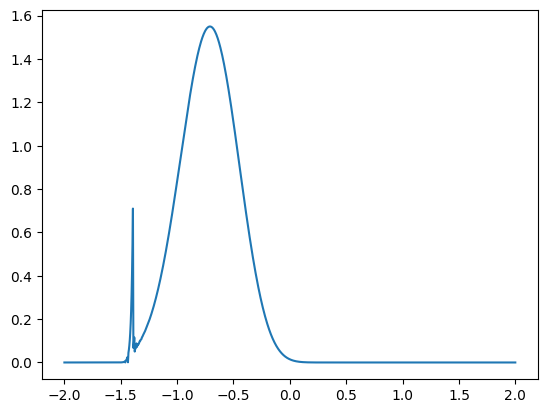

In [ ]:
# Load the specific problematic row in 6dFGS
df = pd.read_csv("../../data/foundation/fp_individual_outlier_rejects/smin_setting_1/fp_fit_method_0/6dfgs.csv")
df = df.loc[[3916]]

# Load common-abc FP
fp_params = pd.read_csv("../../artifacts/fp_fit/smin_setting_1/fp_fit_method_0/abc_fixed/fp_fits_abc_fixed.csv", index_col=0).loc['6dFGS']
fp_params = fp_params[['a', 'b', 'rmean', 'smean', 'imean', 's1', 's2', 's3']].to_numpy()

# Load veldisp lower limit
smin = SURVEY_VELDISP_LIMIT[1]['6dFGS']

# Get some redshift-distance lookup tables
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
dz = sp.interpolate.splev(df["z_cmb"].to_numpy() / LIGHTSPEED, dist_spline)
dz_cluster = sp.interpolate.splev(df["z_dist_est"], dist_spline)

# Define the range of logdists values to be calculated
dmin, dmax, nd = -2.0, 2.0, 1001
dbins = np.linspace(dmin, dmax, nd, endpoint=True)

# Calculate full FN
d_H = np.outer(10.0**(-dbins), dz_cluster)
lmin = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_j"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - MAG_HIGH) / 5.0
lmax = (SOLAR_MAGNITUDE['j'] + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_j"].to_numpy() + df["extinction_j"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - MAG_LOW) / 5.0

# Calculate negative of log likelihood
loglike = FP_func(fp_params, dbins, df["z_cmb"].to_numpy(), df["r"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), np.ones(len(df)), smin, df["lmin"].to_numpy(), df["lmax"].to_numpy(), df["C_m"].to_numpy(), sumgals=False)

# Calculate full FN
FNvals = FN_func(fp_params, df["z_cmb"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), lmin, lmax, smin)

# Calculate log prior
log_prior = -3 * dbins[:, np.newaxis] * np.log(10)

# Convert to the PDF for logdistance
logP_dist = - loglike - FNvals + log_prior

# normalise logP_dist (trapezoidal rule)
ddiff = np.log10(d_H[:-1]) - np.log10(d_H[1:])
valdiff = np.exp(logP_dist[1:]) + np.exp(logP_dist[0:-1])
norm_ = 0.5 * np.sum(valdiff * ddiff, axis=0)

logP_dist -= np.log(norm_[:, None]).T

# Transpose the PDF and return to linear unit
y = np.exp(logP_dist)

plt.plot(dbins, y)

Text(0.5, 0, '$\\eta$')

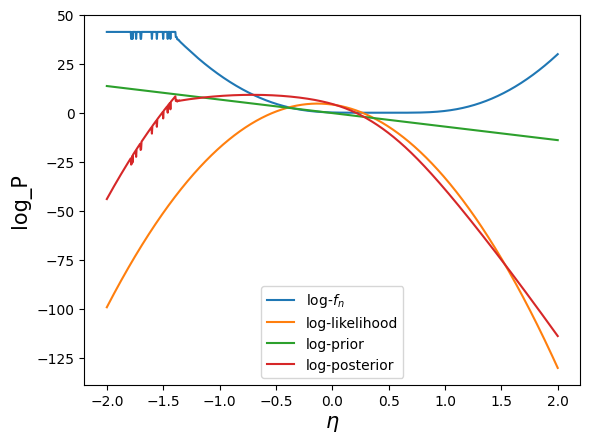

In [6]:
plt.plot(dbins, -FNvals, label=r"log-$f_n$")
plt.plot(dbins, -loglike, label='log-likelihood')
plt.plot(dbins, log_prior, label='log-prior')
plt.plot(dbins, -loglike-FNvals+log_prior, label='log-posterior')

plt.legend()
plt.ylabel('log_P', fontsize=15)
plt.xlabel(r"$\eta$", fontsize=15)

Conclusion: rounding error causes weird behavior at very negative logdists

# Investigate SDSS

1. Why very little change to 1-to-1 line
2. Why shift in the positive logdists

First, 

In [ ]:
dbins = np.linspace(-2, 2, 1001)
y_ = np.load("./malmquist_prior/logdist/6dfgs_posterior.npy")
# y_ = np.load("../../artifacts/logdist/smin_setting_1/fp_fit_method_0/6dfgs_posterior.npy")

y = y_[3916]
plt.plot(dbins, y)